In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import SplitWordsDataset
from src.preprocessing.pet.pet_for_text_classification_dataset import PETDatasetForClassification
from src.model.mlm.trainer import MLMTrainer
from src.model.mlm.pet_for_text_classification import train
import warnings
warnings.filterwarnings("ignore")

In [33]:
!mkdir logs
model_name = "PET"
dataset_name = "SROIE"
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Importing dataset

In [4]:
dataset = load_dataset("darentang/sroie",
                       cache_dir= "/Data/pedro.silva/")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [15]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL',
 'I-TOTAL']

In [155]:
class2idx = {
    # "none": 0,
    "company" : 0,
    "date": 1,
    "address" : 2,
    "total": 3
}

idx2class = {v:k for k,v in class2idx.items()}

class_names = [k for k in class2idx.keys()]

verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [32]:
verbalizer

{0: 3904, 1: 2194, 2: 3058, 3: 4769, 4: 2561}

## Create dataset

In [141]:
def pattern(
    phrase : str, 
    word : str,
    tokenizer : AutoTokenizer
):
    return f"In the phrase {phrase}, the word {word} represents a company, a date, an address, the total value or none of these? {tokenizer.mask_token}"

In [142]:
train_phrases = SplitWordsDataset(
    dataset['train'],
    tokenizer,
    pattern,
)

100%|██████████| 626/626 [00:00<00:00, 1868.17it/s]


In [143]:
validation_phrases  = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern,
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:00<00:00, 1763.63it/s]


In [146]:
def get_processed_text_labels(phrases : List[List[str]],
                              n_shots: int = -1):
    processed_text = []

    labels = []

    for document_text in phrases[0:n_shots]:
        for phrase in document_text:
            processed_text.append(phrase['pattern'])
            labels.append(phrase['label'])

    return processed_text, labels


In [170]:
processed_text_val, labels_val = get_processed_text_labels(validation_phrases, n_shots=50)

In [171]:
validation_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)
validation_dataloader = DataLoader(
    validation_dataset
)

909it [00:05, 162.87it/s]


## Class distribution

In [172]:
first_ten = []
for i in range(10):
    first_ten.append(pd.DataFrame(train_phrases[i]))


In [173]:
pd.concat(first_ten)['label'].value_counts()

label
address    120
company     44
total       16
date        11
Name: count, dtype: int64

## Training

### 2 shots

In [174]:
n_shots = 2
processed_text, labels = get_processed_text_labels(train_phrases, n_shots)


In [175]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

0it [00:00, ?it/s]

40it [00:00, 151.75it/s]


In [176]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-4
)

f1-score : 0.8536853790283203
tensor([[164,   0,  45,   0],
        [  0,  45,  30,   1],
        [ 50,   0, 496,   0],
        [  2,   0,   5,  71]], device='cuda:0')


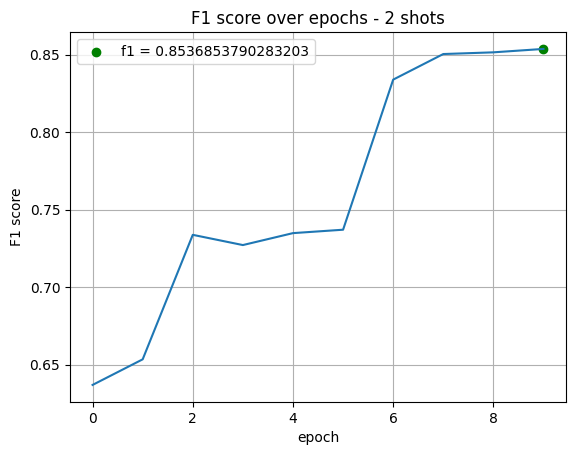

In [179]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix SROIE - 2 shots')

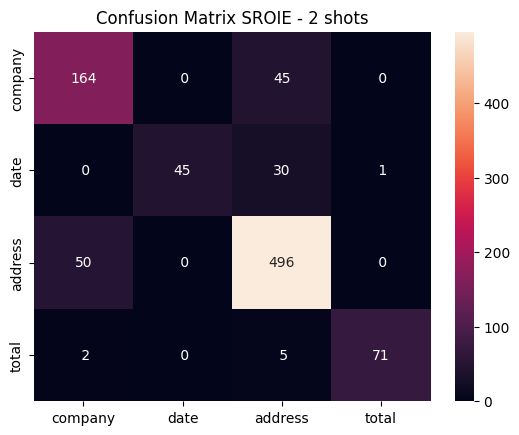

In [180]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")

### 5 shots

In [181]:
n_shots = 5
processed_text, labels = get_processed_text_labels(train_phrases, n_shots)


In [182]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

0it [00:00, ?it/s]

101it [00:00, 149.24it/s]


In [186]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-4,
    n_epochs=15
)

f1-score : 0.908690869808197
tensor([[170,   0,  39,   0],
        [  0,  45,  30,   1],
        [ 11,   0, 535,   0],
        [  0,   0,   2,  76]], device='cuda:0')


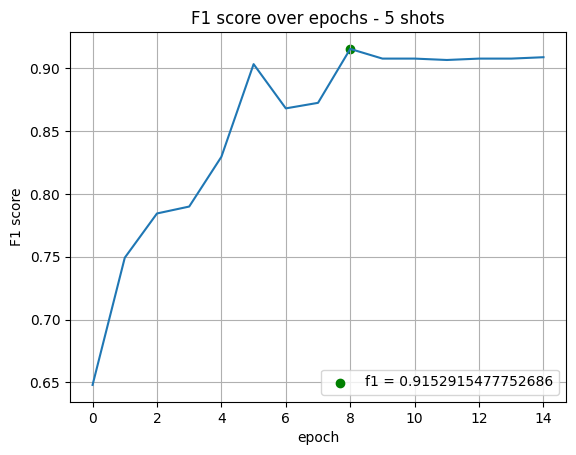

In [187]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix SROIE - 5 shots')

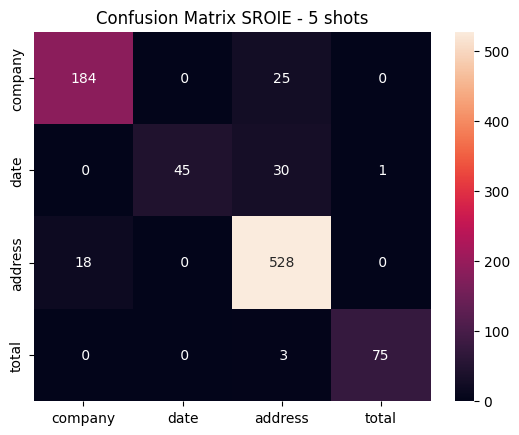

In [188]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")

### 10 shots

In [189]:
n_shots = 10
processed_text, labels = get_processed_text_labels(train_phrases, n_shots)


In [190]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

0it [00:00, ?it/s]

191it [00:01, 153.69it/s]


In [191]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-4,
    n_epochs=15
)

f1-score : 0.9207921028137207
tensor([[172,   0,  35,   2],
        [  0,  49,  26,   1],
        [  4,   0, 541,   1],
        [  0,   0,   3,  75]], device='cuda:0')


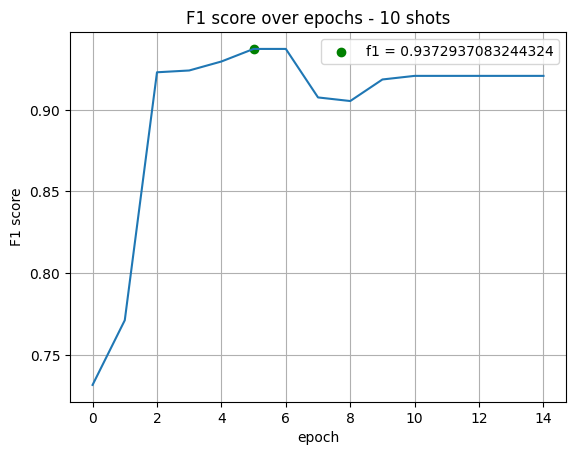

In [192]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix SROIE - 10 shots')

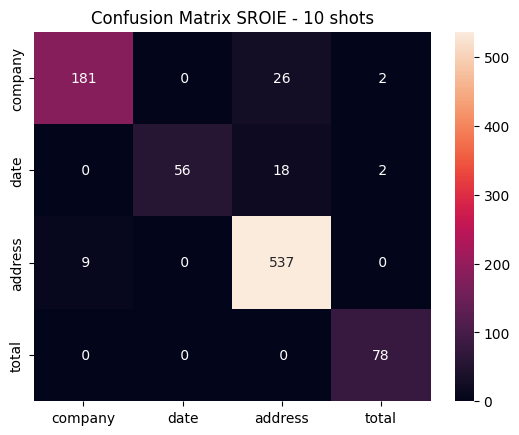

In [193]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")